In [0]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision as tv
import torchvision.models as models
from PIL import Image
import glob
import os
import time
from torch.optim import lr_scheduler
import copy
from torch.autograd import Variable
import matplotlib.pyplot as plt


# Computation Routines

## Load data

In [0]:
class DatasetManager:
    
    def __init__(self, dataset = 'cifar10', percent_data = 10.0, percent_val = 20.0, data_path = './data'):
        
        # 'dataset' can be 'hymenoptera', 'cifar10', or 'cifar100'.
        # 'percent_data' is the percentage of the full training set to be used.
        # 'percent_val' is the percentage of the *loaded* training set to be used as validation data.
        
        self.dataset = dataset
        self.data_path = data_path
        self.percent_data = percent_data
        self.percent_val = percent_val
        
        if self.dataset == 'hymenoptera':

            self.transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            
        elif self.dataset == 'cifar10' or self.dataset == 'cifar100':

            self.transform = tv.transforms.Compose([
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        return
    
    
    def ImportDataset(self, batch_size=5):
        
        self.batch_size = batch_size
        
        if self.dataset == 'hymenoptera':
        
            self.trainset = tv.datasets.ImageFolder(root=self.data_path,
                             transform=self.transform)
        
        # todo
        
        elif self.dataset == 'cifar10':

            self.trainset = tv.datasets.CIFAR10(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.CIFAR10(root=self.data_path, train=False,
                                       download=True, transform=self.transform)
        
        elif self.dataset == 'cifar100':

            self.trainset = tv.datasets.CIFAR100(root=self.data_path, train=True,
                                        download=True, transform=self.transform)

            self.testset = tv.datasets.CIFAR100(root=self.data_path, train=False,
                                       download=True, transform=self.transform)
             
        self.SplitData();
        self.GenerateLoaders();
                
        return
    
    
    def SplitData(self):
        
        len_full = self.trainset.__len__()
        len_train = int(np.round(len_full*self.percent_data/100.0))
        
        _, self.trainset = torch.utils.data.random_split(self.trainset, (len_full-len_train, len_train))
        
        len_val = int(np.round(len_train*self.percent_val/100.0))
        len_train = len_train - len_val
        
        self.valset, self.trainset = torch.utils.data.random_split(self.trainset, (len_val, len_train))
         
        len_full_test = self.testset.__len__()
        len_test = int(np.round(len_full_test*self.percent_data/100.0))
        
        _, self.testset = torch.utils.data.random_split(self.testset, (len_full_test-len_test, len_test))

        print('\nFull training set size: {}'.format(len_full))
        print('Full test set size: {}'.format(len_full_test))
        print('\nActive training set size: {}'.format(len_train))
        print('Active validation set size: {}'.format(len_val))
        print('Active test set size: {}\n'.format(len_test))
        
        return
    
    
    def GenerateLoaders(self):
        
        self.train_loader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        self.val_loader = torch.utils.data.DataLoader(self.valset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)
        self.test_loader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=0)          
            
        return
    

## Training function

In [0]:
def train_model(model, dat, criterion, optimizer, scheduler, prune_settings=0, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                scheduler.step()
                dataloader = dat.train_loader
                dataset_size = dat.trainset.__len__()
                
                model.train()  # Set model to training mode
                
            else:
                
                model.eval()   # Set model to evaluate mode
                dataloader = dat.val_loader
                dataset_size = dat.valset.__len__()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if prune_settings != 0:
                    TrackConv2DNorms(model, prune_settings, inputs)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Record losses for later use, plotting etc
            if phase == 'train':
                prune_settings.epoch_loss.append(epoch_loss)
                prune_settings.epoch_acc.append(epoch_acc)
            elif phase == 'val':
                prune_settings.val_loss.append(epoch_loss)
                prune_settings.val_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model


## Pruning functions

### Pruning settings

In [0]:

# Constants that define possible pruning metrics
WEIGHT_NORM = 1
ACT_NORM = 2

# Class that contains various settings pertaining to how filters are pruned
class UnitPruningSettings:
    
    def __init__(self, idx_layer=0, idx_filter=0, N_prune=1, P_prune=10, p=2, pruning_metric=WEIGHT_NORM):
        
        # EITHER N_prune OR P_prune will be used to decide how many filters to prune.
        # If one is non-positive, the other is used.
        # If neither is non-positive, priority is given to P_prune.
        # If both are non-positive, no pruning will happen.

        self.N_prune = N_prune # Number of filters allowed to be pruned in one pass
        self.P_prune = P_prune; # Percent of filters of the current layer to prune
        
        self.idx_filter = idx_filter # Indices of the N_prune filters
        self.idx_layer = idx_layer # Current layer under consideration
        self.p = p # p-norm to use when computing which filters to remove
        self.pruning_metric = pruning_metric
        
        self.norms_botk = []
        self.idx_norms_botk = []
        
        # Various statistics will be stored and computed to keep track of how the network changes
        
        # Number of filters per layer in the original network
        self.filters_per_layer_orig = []
        
        # Number of filters per layer after pruning - this gets updated every time the network is pruned
        self.filters_per_layer_after = []
        
        # Time taken to prune in sec (running total, updated every time pruning happens)
        self.prune_time = 0.0
        
        # Keep track of running epoch loss and validation loss, and corresponding accuracy
        self.epoch_loss = []
        self.val_loss = []
        self.epoch_acc = []
        self.val_acc = []
        
        return
    
    # Function to print the current pruning state of the model. Verbose can be 0, 1, or 2.
    def PrintPruningStatistics(self, verbose=1):
    
        if verbose == 0:
            return
        
        print("Total number of filters before pruning: {}".format(sum(self.filters_per_layer_orig)))
        print("Total number of filters after pruning: {}".format(sum(self.filters_per_layer_after)))
    
        return
    
    # Function to set up and initialize based on a given model
    def Setup(self, model):
        
        # Count the number of conv layers
        self.N_layers = 0
        
        for layer, (name, module) in enumerate(model.features._modules.items()):
            self.N_layers += 1
                    
        # Initialize storage containers
        self.norms_botk = [None]*self.N_layers
        self.idx_norms_botk = [None]*self.N_layers
        
    
    # Function to reset norm containers
    def ResetNormContainers(self):
    
        self.norms_botk = [None]*self.N_layers
        self.idx_norms_botk = [None]*self.N_layers
    
        return

    # Function to reset filter containers
    def ResetFilterContainers(self):
    
        self.filters_per_layer_orig = []
        self.filters_per_layer_after = []
    
        return

        




### Pruning decisions

In [0]:
# Function to compute the p-norm of weights in all filters of a given layer.
# The list of norms are returned in a list in the same order as that in which filters of that layer are stored.
def ComputeConv2DWeightNorms(model, idx_layer, p):
    
    # Extract the layer of the model currently being considered
    _, conv = list(model.features._modules.items())[idx_layer]
    weights = conv.weight.data

    # Compute norms of each filter
    norms = weights.norm(p, dim=2).norm(p, dim=2).norm(p, dim=1)
    
    return norms


# Function to compute the p-norm of activations in all filters per layer.
# The list of norms are returned in a list in the same order as that in which filters of that layer are stored.
def ComputeConv2DActNorms(activation, prune_settings):
    
    p = prune_settings.p
    
    # Compute norms of each activation
    norms = torch.norm(activation, p, dim=0).norm(p, dim=1).norm(p, dim=1)
        
    return norms


# Function to track the p-norm of activations of all filters of during training.
def TrackConv2DNorms(model, prune_settings, inputs):
    
    p = prune_settings.p
    P_prune = prune_settings.P_prune

    x = Variable(inputs)

    ii = -1
    for layer, (name, module) in enumerate(model.features._modules.items()):
        ii += 1
        x = module(x)
        
        if isinstance(module, torch.nn.modules.conv.Conv2d):
            
            if prune_settings.pruning_metric == WEIGHT_NORM:
                norms = ComputeConv2DWeightNorms(model, ii, p)
            elif prune_settings.pruning_metric == ACT_NORM:
                norms = ComputeConv2DActNorms(x, prune_settings)

            # Use the given prune percentage to figure out how many filters to prune
            if (P_prune >= 0):
                N_prune = int(len(norms.float())*P_prune/100.0)
                prune_settings.N_prune = N_prune

#             n_botk, ind_botk = torch.topk(norms, N_prune, 0, largest=False, sorted=True, out=None)
            norms = norms.cpu().detach().numpy()
    
            # Store the norms for each filter
#             if prune_settings.norms_botk[ii] is None:
#                 prune_settings.norms_botk[ii] = norms
#             else:
#                 prune_settings.norms_botk[ii] += norms
                
            # Store normalized norms for each filter
            if prune_settings.norms_botk[ii] is None:
                prune_settings.norms_botk[ii] = norms/max(norms)
            else:
                prune_settings.norms_botk[ii] += norms/max(norms)
                
    return

### Pruning workers

In [0]:
# The following functions were adapted from https://github.com/jacobgil/pytorch-pruning/blob/master/prune.py

def replace_layers(model, i, idx, layers):
	if i in idx:
		return layers[idx.index(i)]
	return model[i]


# Function to prune a given convolution layer in the model provided.
# Input "idx_layers" is the global index of the convolution layer to be pruned.
# Input "prune_settings" is a data structure containing information on how pruning is performed.
def PruneConvLayers(model, prune_settings):
    
    # Strategy: in order to prune a particular layer, the output of the previous layer 
    # and the inputs to the next layer must also be altered accordingly.
	
    # Extract pruning settings for convenience
    N_prune = prune_settings.N_prune
    idx_filter = prune_settings.idx_filter
    idx_layer = prune_settings.idx_layer
    
    if idx_layer >= len(model.features._modules.items()):
        return
        
    # Extract the layer of the model currently being pruned
    _, conv = list(model.features._modules.items())[idx_layer]
    

    # In case the list of target filters to delete has out-of-range entries, detect and ignore them
    del_filters = []
    for kk in range(0, len(idx_filter)):
        if idx_filter[kk] >= conv.out_channels:
            del_filters.extend(kk)
    
    if (len(del_filters) > 0):
        idx_filter = np.delete(idx_filter, del_filters, 0)
        N_prune = len(idx_filter)
        prune_settings.N_prune = N_prune
        print("[WARNING] Encountered an out-of-range target filter; it will be ignored.")
    
    # Record pruning statistics
    prune_settings.filters_per_layer_orig[idx_layer] = conv.out_channels
    prune_settings.filters_per_layer_after[idx_layer] = conv.out_channels - N_prune
    
        
    # To keep track of the succeeding convolution layer
    next_conv = None
    offset = 1
    
    # Figure out how many layers after this one are NOT conv layers, in order to skip pruning them
    while idx_layer + offset < len(model.features._modules.items()):
        
        res =  list(model.features._modules.items())[idx_layer + offset]
        if isinstance(res[1], torch.nn.modules.conv.Conv2d):
            next_name, next_conv = res
            break
        offset = offset + 1
    
    # Create a new, replacement conv layer to remove a given number of filters.
    # The rest of its settings should remain the same as the original conv layer.
    new_conv = torch.nn.Conv2d(in_channels = conv.in_channels,
                               out_channels = conv.out_channels - N_prune,
			                   kernel_size = conv.kernel_size,
                               stride = conv.stride,
                               padding = conv.padding,
                               dilation = conv.dilation,
                               groups = conv.groups,
                               bias = True)
    
    new_conv.bias = conv.bias
    
    # Copy over the weights to the new conv layer, except the ones corresponding to the filter to be removed
    old_weights = conv.weight.data.cpu().numpy()
    new_weights = new_conv.weight.data.cpu().numpy()
    
    # Copy over the set of filters, excluding the ones to be removed
    new_weights_temp = np.copy(old_weights)
    new_weights_temp = np.delete(new_weights_temp, idx_filter, 0)
    new_weights[:, :, :, :] = new_weights_temp[:, :, :, :]

    # Update weight data of the new conv layer
    new_conv.weight.data = torch.from_numpy(new_weights).cuda()
    
    # Now do the same thing for biases
    old_biases = conv.bias.data.cpu().numpy()
    new_biases = np.zeros(shape=(old_biases.shape[0] - N_prune), dtype=np.float32)
    
    new_biases_temp = np.copy(old_biases)
    new_biases_temp = np.delete(new_biases_temp, idx_filter, 0)
    new_biases[:] = new_biases_temp[:]
        
    new_conv.bias.data = torch.from_numpy(new_biases).cuda()
    
    # If there is a succeeding conv layer, adjust its input units and weights accordingly
    if next_conv != None:
        
        next_new_conv = torch.nn.Conv2d(in_channels = next_conv.in_channels - N_prune,
                                        out_channels =  next_conv.out_channels,
                                        kernel_size = next_conv.kernel_size,
                                        stride = next_conv.stride,
                                        padding = next_conv.padding,
                                        dilation = next_conv.dilation,
                                        groups = next_conv.groups,
                                        bias = True)
        
        next_new_conv.bias = next_conv.bias

        old_weights = next_conv.weight.data.cpu().numpy()
        new_weights = next_new_conv.weight.data.cpu().numpy()
        
        # Copy over the set of filters, excluding the ones to be removed
        new_weights_temp = np.copy(old_weights)
        new_weights_temp = np.delete(new_weights_temp, idx_filter, 1)
        new_weights[:, :, :, :] = new_weights_temp[:, :, :, :]

        next_new_conv.weight.data = torch.from_numpy(new_weights).cuda()

        # Now do the same thing for biases
        next_new_conv.bias.data = next_conv.bias.data

        # Update the actual model by replacing the existing filters with the new ones
        features = torch.nn.Sequential(
                *(replace_layers(model.features, i, [idx_layer, idx_layer + offset], \
                    [new_conv, next_new_conv]) for i, _ in enumerate(model.features)))
        del model.features
        del conv

        model.features = features
    
    else:

        # This is the last conv layer. This affects the first linear layer of the classifier.
        model.features = torch.nn.Sequential(*(replace_layers(model.features, i, [idx_layer], [new_conv]) for i, _ in enumerate(model.features)))
        idx_layer = 0
        old_linear_layer = None

        for _, module in model.classifier._modules.items():
            if isinstance(module, torch.nn.Linear):
                old_linear_layer = module
                break
            idx_layer = idx_layer + 1

        if old_linear_layer == None:
            raise BaseException("No linear layer found in classifier.")
            
        params_per_input_channel = int(old_linear_layer.in_features/conv.out_channels)

        new_linear_layer = torch.nn.Linear(old_linear_layer.in_features - N_prune*params_per_input_channel, 
                                           old_linear_layer.out_features)

        old_weights = old_linear_layer.weight.data.cpu().numpy()
        new_weights = new_linear_layer.weight.data.cpu().numpy()	 	

        # Copy over the set of filters, excluding the ones to be removed
        new_weights_temp = np.copy(old_weights)
        idx_expanded = np.zeros(shape=(N_prune*params_per_input_channel))
        
        for kk in range(0, len(idx_filter)):
            idx_expanded[kk*params_per_input_channel:kk*params_per_input_channel+params_per_input_channel] = np.arange(idx_filter[kk]*params_per_input_channel, idx_filter[kk]*params_per_input_channel + params_per_input_channel)

        new_weights_temp = np.delete(new_weights_temp, idx_expanded.astype(int), 1)
        new_weights[:, :] = new_weights_temp[:, :]
        
        new_linear_layer.bias.data = old_linear_layer.bias.data
        new_linear_layer.weight.data = torch.from_numpy(new_weights).cuda()

        classifier = torch.nn.Sequential(*(replace_layers(model.classifier, i, [idx_layer], [new_linear_layer]) for i, _ in enumerate(model.classifier)))

        del model.classifier
        del next_conv
        del conv
        model.classifier = classifier
        
    return model


### Pruning driver

In [0]:
# Function to iterate through all conv2D layers of the network and determine 
# filters to be pruned, and then carry out the pruning.
def PruneAllConv2DLayers(model, prune_settings):
    
    # Extract pruning settings for convenience
    # Note that "N_prune" *consecutive* filters will get pruned
    N_prune = prune_settings.N_prune
    P_prune = prune_settings.P_prune
    p = prune_settings.p
    pruning_metric = prune_settings.pruning_metric
    
    # Count number of prunable layers for preallocation
    N_layers = len(model.features._modules.items())       
    prune_settings.filters_per_layer_orig = np.zeros(shape=(1, N_layers)).ravel()
    prune_settings.filters_per_layer_after = np.zeros(shape=(1, N_layers)).ravel()

    
    # Find the N_prune filters to remove
    ii = 0
    while ii < len(model.features._modules.items()):
        
        res = list(model.features._modules.items())[ii]
        
        if isinstance(res[1], torch.nn.modules.conv.Conv2d):
            
            _, conv = list(model.features._modules.items())[ii]
            
            # Record pruning statistics
            prune_settings.filters_per_layer_orig[ii] = conv.out_channels
            prune_settings.filters_per_layer_after[ii] = conv.out_channels
            
            # Compute values and indices of the N_prune smallest norms
#             if pruning_metric == WEIGHT_NORM:
#                 norms = ComputeConv2DWeightNorms(model, ii, p)
#             elif pruning_metric == ACT_NORM:
# #                 norms = ComputeConv2DWeightNorms(model, ii, p)
#                 norms = ComputeConv2DActNorms(res[1], prune_settings)
                
        
            if (P_prune >= 0):
                N_prune = int(conv.out_channels*P_prune/100.0)
                prune_settings.N_prune = N_prune
            
            if prune_settings.norms_botk[ii] is not None:
                
#                 n_botk, ind_botk = torch.topk(torch.from_numpy(prune_settings.norms_botk[ii]), N_prune, 0, largest=False, sorted=True, out=None)
            
                norms = np.asarray(prune_settings.norms_botk[ii]).ravel()
                ind_botk = np.argpartition(norms, N_prune)    
                n_botk = norms[ind_botk[:N_prune]]
                ind_botk = ind_botk[:N_prune]
        
                prune_settings.idx_layer = ii
                prune_settings.idx_filter = ind_botk

                model = PruneConvLayers(model, prune_settings)
                
        ii = ii + 1
            
    return model


## Test Pruning

In [8]:
# Test pruning

model = models.vgg16(pretrained=True)
model.train()

# Pruning setup
prune_settings = UnitPruningSettings(idx_layer=28, idx_filter=(10, 12, 15, 16, 21), 
                                     N_prune=5, p=2, pruning_metric=WEIGHT_NORM)
# prune_settings = UnitPruningSettings(idx_layer=28, idx_filter=(10), 
#                                      N_prune=1, p=2, pruning_metric=WEIGHT_NORM)

N_layers = len(model.features._modules.items())       
prune_settings.filters_per_layer_orig = np.zeros(shape=(1, N_layers)).ravel()
prune_settings.filters_per_layer_after = np.zeros(shape=(1, N_layers)).ravel()

t0 = time.time()
model = PruneConvLayers(model, prune_settings)
print ("Pruning took {} s".format(time.time() - t0))


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:11, 49592333.49it/s]


Pruning took 10.873862981796265 s


# Model Setup Routines

## Baseline Model Setup

In [0]:
model_baseline = models.vgg16(pretrained=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_baseline = model_baseline.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


## Pruned Model Setup

In [37]:
# Test pruning all layers

model_pruned = models.vgg16(pretrained=True)
model_pruned.train()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pruned = model_pruned.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_pruned.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Pruning setup
prune_settings = UnitPruningSettings(28, 10, N_prune = 4, p = 2, pruning_metric = WEIGHT_NORM)

t0 = time.time()
model_pruned = PruneAllConv2DLayers(model_pruned, prune_settings)
print ("Pruning took {} s".format(time.time() - t0))


IndexError: ignored

# Driver Routines

## Iterative Pruning

In [20]:
# ====== Dataset setup ======

percent_data = 1.0
percent_val = 20.0
batch_size = 5


# ====== Model setup ======

model = models.vgg16(pretrained=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# ====== Pruning setup ======

N_prune = 0
P_prune = 5
p = 2
prune_settings = UnitPruningSettings(N_prune=N_prune, 
                                     P_prune=P_prune, 
                                     p=p, 
                                     pruning_metric=WEIGHT_NORM)
prune_settings.Setup(model)


# ====== Begin training ======

N_iter_outer = 10
N_iter_inner = 10

# Import data
dat = DatasetManager(dataset='cifar10', 
                     percent_data=percent_data, 
                     percent_val=percent_val)

dat.ImportDataset(batch_size=batch_size)

for ii in range(0, N_iter_outer):
    
    print("\n------ Outer iteration {}/{} ------".format(ii+1, N_iter_outer))
#     t0 = time.time()

    # ------ Prune current model ------
        
    model = PruneAllConv2DLayers(model, prune_settings)
    new_model = copy.deepcopy(model)
    model = new_model
    prune_settings.PrintPruningStatistics(1)
    prune_settings.ResetNormContainers()

    # ------ Train current model ------
    
    # Import data
    dat = DatasetManager(dataset='cifar10', percent_data=percent_data, percent_val=percent_val)
    dat.ImportDataset(batch_size=batch_size)
    
    # Update optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    criterion = nn.CrossEntropyLoss()
    
    model = train_model(model, dat, criterion, optimizer, exp_lr_scheduler, prune_settings, num_epochs=N_iter_inner)
        
#     print ("Pruning took {} s".format(time.time() - t0))







Files already downloaded and verified
Files already downloaded and verified

Full training set size: 50000
Full test set size: 10000

Active training set size: 400
Active validation set size: 100
Active test set size: 100


------ Outer iteration 1/10 ------
Total number of filters before pruning: 4224.0
Total number of filters after pruning: 4224.0
Files already downloaded and verified
Files already downloaded and verified

Full training set size: 50000
Full test set size: 10000

Active training set size: 400
Active validation set size: 100
Active test set size: 100

Epoch 1/10
----------
train Loss: 4.5017 Acc: 0.0925
val Loss: 2.9637 Acc: 0.0900

Epoch 2/10
----------
train Loss: 2.6241 Acc: 0.1200
val Loss: 2.4863 Acc: 0.0400

Epoch 3/10
----------
train Loss: 2.5566 Acc: 0.0925
val Loss: 2.5447 Acc: 0.0400

Epoch 4/10
----------
train Loss: 2.4681 Acc: 0.1100
val Loss: 2.4994 Acc: 0.1800

Epoch 5/10
----------
train Loss: 2.3919 Acc: 0.1325
val Loss: 2.2881 Acc: 0.0600

Epoch 6/10

### Plot

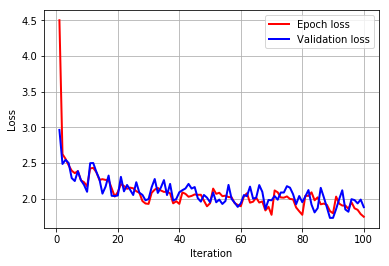

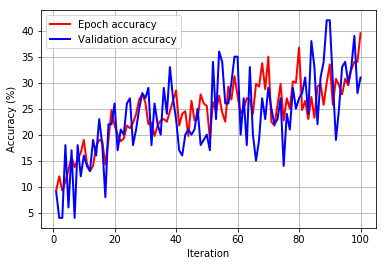

In [21]:
# ====== Plot ======

# ------ Loss ------

plt.figure()
plt.plot(np.arange(1, N_iter_outer*N_iter_inner+1), 
         prune_settings.epoch_loss, 
         color='red', 
         marker='',  markersize=12, 
         linestyle='-', linewidth=2,
         label='Epoch loss')
plt.plot(np.arange(1, N_iter_outer*N_iter_inner+1), 
         prune_settings.val_loss, 
         color='blue', 
         marker='',  markersize=12, 
         linestyle='-', linewidth=2,
         label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# ------ Accuracy ------

plt.figure()
plt.plot(np.arange(1, N_iter_outer*N_iter_inner+1), 
         np.asarray(prune_settings.epoch_acc)*100.0, 
         color='red', 
         marker='',  markersize=12, 
         linestyle='-', linewidth=2,
         label='Epoch accuracy')
plt.plot(np.arange(1, N_iter_outer*N_iter_inner+1), 
         np.asarray(prune_settings.val_acc)*100.0, 
         color='blue', 
         marker='',  markersize=12, 
         linestyle='-', linewidth=2,
         label = 'Validation accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()


# Training Routines

## Train Baseline Model

In [0]:
# Import data
dat = DatasetManager('cifar10', 1.0, 20.0)
dat.ImportDataset(5)

model_baseline.train()

model_baseline = train_model(model_baseline, dat, criterion, optimizer, exp_lr_scheduler, num_epochs=25)


## Train Pruned Model

In [0]:
# Import data
dat = DatasetManager('cifar10', 1.0, 20.0)
dat.ImportDataset(5)

model.train()

model = train_model(model, dat, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
